## Анализ данных и постановка задачи

**Имеющиеся данные:**
1.  **Сигналы КТГ:** временные ряды (ЧСС плода - FHR и тонус матки - UC).
2.  **Газы крови:** объективный лабораторный показатель, редко измеряемый (заполняемость стремится к 0 в наборе данных).
3.  **Медицинские диагнозы:** текстовые записи из медкарт, охватывающие широкий спектр состояний (как акушерских, так и сопутствующих).

**КТГ и газы крови** объективно отражают состояние плода в момент измерения (риск гипоксии, ацидемии, дистресса). Они являются нашими основными **потенциальными предикторами**.  
Однако многие диагнозы из медкарт (например, *эндометриоидная киста яичника, варикозная болезнь, рубец на матке*) являются фоновыми и **не имеют прямой мгновенной корреляции** с сигналами КТГ или показателями газов крови. Они описывают общий контекст здоровья матери, а не текущее состояние плода.  
**Газы крови** — точечный и редкий замер, что делает их **непригодными для использования в качестве таргета в модели потоковой обработки**, так как их значения не изменяются моментально с каждым новым отсчетом КТГ.  
**Текстовые диагнозы** являются разрозненными, слабоструктурированными данными, требующими отдельной обработки и большего количества примеров.

### Формулировка решаемой задачи

Учитывая природу данных, мы не можем и не должны пытаться предсказывать все диагнозы сразу. Задачу **необходимо сузить** до прогнозирования состояний, которые **непосредственно и с минимальной задержкой отражаются на сигнале КТГ**.

**Таким образом, реальной целью прогнозирования могут быть следующие острые состояния плода:**

1.  **Патологические паттерны КТГ:** Классификация сигналов в реальном времени согласно международным критериям (например, FIGO). Это наша **основная и самая надежная целевая переменная**.
2.  **Риск острой гипоксии:** Может быть использован как **«слабый» признак (weak label)**, так как не имеет строгого количественного определения и часто выводится ретроспективно на основе КТГ и клинической картины.
3.  **Метаболический ацидоз:** Является **«жестким» признаком (hard label)**, подтвержденным газами крови. Однако из-за редкости измерений его можно использовать не для потокового прогноза, а как **валидационный критерий** для проверки уже сработавших алгоритмов на исторических данных. Модель, предсказывающая паттерны КТГ, связанные с ацидозом, будет клинически значимой.

**Вывод:** Наиболее корректный подход — построение модели **классификации паттернов КТГ** в реальном времени. Сопутствующие диагнозы и данные газов крови могут служить дополнительным контекстом для валидации и обогащения модели, но не являются первичной целью для потокового прогноза.

### **FIGO**

FIGO  — это, по сути, правила игры, разработанные профессиональными сообществами для того, чтобы врачи одинаково трактовали КТГ.  
**FIGO** = *International Federation of Gynecology and Obstetrics* (Международная федерация гинекологии и акушерства).

Ключевые элементы:

* **Baseline FHR** (средний уровень ЧСС(bpm) плода за 10 мин): нормальный 110–160 bpm.
* **Variability** (вариабельность): нормальная 5–25 bpm, <5 bpm более 40 мин — подозрительно, более 90 мин — патологично.
* **Accelerations**: ≥2 акцелерации за 20 мин — признак благополучия.
* **Decelerations**:

  * **ранние** (синхронные со схватками) — обычно неопасны;
  * **вариабельные** — допустимы, если редкие и <60 сек, но патологичны, если повторяются и длинные;
  * **поздние** (начинаются после схватки) — подозрение на гипоксию.
* **Tachycardia**: >160 bpm устойчиво.
* **Bradycardia**: <110 bpm.

---

### Для нашей задачи

Мы используем эти критерии как суррогатные таргеты:

* можем запрограммировать правила (baseline, вариабельность, деселерации),
* по ним автоматически размечать окна КТГ,
* и обучать модель предсказывать риск появления таких «патологических» паттернов.


То есть по признакам в окне (H минут) → вероятность, что в следующем горизонте (F минут) наступит проблема (гипоксия / неблагоприятный FIGO-эпизод)

In [1]:
import os
from pathlib import Path

from dataclasses import dataclass

import numpy as np
import math
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import medfilt, welch, find_peaks, correlate
from scipy.ndimage import label

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_curve, roc_curve
from catboost import CatBoostClassifier, Pool
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams.update({
    "figure.facecolor": "white",    
    "figure.autolayout": True,     
})

import warnings
warnings.filterwarnings("ignore")

In [2]:
@dataclass
class Params:
    
    seed: int = 42
    data_dir = "/kaggle/input/lct-data"
    regular_csv = os.path.join(data_dir, "regular_csv.csv")
    hypoxia_csv = os.path.join(data_dir, "hypoxia_csv.csv")
    regular_dir = os.path.join(data_dir, "regular")
    hypoxia_dir = os.path.join(data_dir, "hypoxia")

    kernel_size: int = 7 # размер ядра для сглаживания
    alpha: float = 0.04 # коэф-нт для экспоненциального сглаженный baseline FHR.
     
    fs: float = 1.0 # Общий сэмплинг (Гц) после унификации
    baseline_minutes: float = 5.0        # окно для baseline (минуты)

    # UC (uterine contractions) detection
    uc_min_distance_s: float = 30.0      # минимальное расстояние между пиками схваток (сек), чтобы не слипались
    uc_min_width_s: float = 20.0         # минимальная длительность схватки (сек)
    uc_rel_start: float = 0.30           # относительный уровень (30% от высоты), где ищем начало/конец схватки
    uc_prominence_min: float = 5.0       # абсолютный минимум "выраженности" пика UC
    uc_prominence_k_mad: float = 4.0     # порог проминенса как 4*MAD (робастная дисперсия)
    uc_height_k_mad: float = 3.0         # минимальная высота пика над локальной базой = 3*MAD
    uc_local_base_window_s: float = 20.0
    
    # Decelerations (FIGO criteria) 
    decel_min_drop_bpm: float = 15.0     # падение ЧСС плода ≥15 ударов/мин от базовой линии
    decel_min_duration_s: float = 15.0   # длительность падения ≥15 сек (иначе игнорируется)
    prolonged_decel_min_s: float = 60.0 # пролонгированная деселерация ≥1 минут
    abrupt_onset_s: float = 30.0         # граница «абруптного» начала (вариабельная деселерация: начало <30 сек)
    
    # Accelerations (FIGO criteria)
    accel_min_rise_bpm: float = 15.0     # подъём ЧСС плода ≥15 ударов/мин
    accel_min_duration_s: float = 15.0   # длительность подъёма ≥15 сек
    accel_total_threshold: float = 4

    
    # Variability 
    low_var_bpm: float = 5.0             # низкая вариабельность: стандартное отклонение <5 ударов/мин
    low_var_min_s: float = 600.0         # длительность низкой вариабельности ≥10 минут (600 сек)
    
    # Tachycardia / Bradycardia
    tachy_bpm: float = 160.0             # тахикардия: baseline >160 уд/мин
    brady_bpm: float = 110.0             # брадикардия: baseline <110 уд/мин

P = Params()

## Загрузка данных

In [3]:
def _to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s in {"–", "-", ""}:
        return np.nan
    s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

In [4]:
def read_meta(csv_path: str) -> pd.DataFrame:
    """
    Читает .csv файл мета информации со столбцами:
      Folder_id, Диагноз, Ph, CO2, Glu, LAC, BE
    Делает числовые поля для газов и ставит бинарный ярлык acid_label (жёсткий исход).
    Обрабатывает Folder_id с пробелами и запятыми как разделителями.
    """
    df = pd.read_csv(
        csv_path,
        header=1,
        usecols=[0, 1, 2, 3, 4, 5, 6],
        names=["Folder_id", "Диагноз", "Ph", "CO2", "Glu", "LAC","BE"],
        converters={"Folder_id": str, "Диагноз": str}
    )
    
    out = pd.DataFrame()
    
    # разделение по пробелам и запятым, создание отдельных строк (раздувание по папкам с информацией)
    folder_ids = []
    diagnosis_texts = []
    ph_values = []
    co2_values = []
    glu_values = []
    lac_values = []
    be_values = []
    
    for _, row in df.iterrows():
        if pd.notna(row["Folder_id"]):
            folder_parts = str(row["Folder_id"]).replace(",", " ").split()
            for folder_part in folder_parts:
                folder_ids.append(folder_part.strip())
                diagnosis_texts.append(row["Диагноз"] if pd.notna(row["Диагноз"]) else "")
                ph_values.append(row["Ph"])
                co2_values.append(row["CO2"])
                glu_values.append(row["Glu"])
                lac_values.append(row["LAC"])
                be_values.append(row["BE"])
    
    out["folder_id"] = folder_ids
    out["diagnosis_text"] = diagnosis_texts
    out["ph"] = pd.Series(ph_values).map(_to_float)
    out["co2"] = pd.Series(co2_values).map(_to_float)
    out["glu"] = pd.Series(glu_values).map(_to_float)
    out["lac"] = pd.Series(lac_values).map(_to_float)
    out["be"] = pd.Series(be_values).map(_to_float)

    # Жёсткая ацидемия
    hard_acid = (out["ph"] < 7.00) & (out["be"] <= -12)
    # Умеренная ацидемия
    mod_acid  = (out["ph"] < 7.10) & (out["be"] <= -8)
    # Лактат
    lac_mod   = out["lac"] >= 4
    lac_severe= out["lac"] >= 8

    out["acid_label_strict"]   = ((hard_acid) | (lac_severe)).astype("Int64")
    out["acid_label_moderate"] = ((mod_acid) | (lac_mod)).astype("Int64")

    file_type = "regular" if "regular" in str(csv_path).lower() else "hypoxia"

    if file_type == "regular":
        out["hypoxia_label"] = 0 # слабая аннотация — вся таблица = нет гипоксии
    else:
        out["hypoxia_label"] = 1  # слабая аннотация — вся таблица = гипоксия

    return out

In [5]:
meta_regular = read_meta(P.regular_csv)
meta_hypoxia = read_meta(P.hypoxia_csv)

In [6]:
meta_hypoxia.head()

,folder_id,diagnosis_text,ph,co2,glu,lac,be,acid_label_strict,acid_label_moderate,hypoxia_label
0,2,Беременность 40-41 неделя. \nГоловное предлежа...,NaN,NaN,NaN,NaN,NaN,0,0,1
1,12,I своевременные оперативные роды\nОстрая гипок...,NaN,NaN,NaN,NaN,NaN,0,0,1
2,13,I своевременные оперативные роды\nОстрая гипок...,NaN,NaN,NaN,NaN,NaN,0,0,1
3,22,II своевременные роды.\nРубец на матке после о...,NaN,NaN,NaN,NaN,NaN,0,0,1
4,16,I своевременные роды в 35 лет\nОстрая гипоксия...,NaN,NaN,NaN,NaN,NaN,0,0,1


In [7]:
# meta_regular["folder_id"] = "regular_" + meta_regular["folder_id"].astype(str)
# meta_hypoxia["folder_id"] = "hypoxia_" + meta_hypoxia["folder_id"].astype(str)
# meta_all = pd.concat([meta_regular, meta_hypoxia], ignore_index=True)

In [8]:
def load_channel(folder: str) -> pd.DataFrame:
    """
    Загружает все куски временных рядов из папки (bpm или uterus),
    склеивает по времени и ресемплирует на равномерную сетку.
    """
    files = sorted(Path(folder).glob("*.csv"))
    if not files:
        # Есть папки без файлов
        raise FileNotFoundError(f"Нет файлов в {folder}")

    t_all, v_all = [], []
    offset = 0.0
    for f in files:
        df = pd.read_csv(f)
        t = df["time_sec"].values + offset
        v = df["value"].values
        offset = t[-1] + (t[1] - t[0])  # продолжить время от конца
        t_all.append(t); v_all.append(v)

    t_all = np.concatenate(t_all)
    v_all = np.concatenate(v_all)

    # целевая равномерная сетка
    t_new = np.arange(0, t_all.max(), 1/P.fs)
    # интерполяция
    v_new = np.interp(t_new, t_all, v_all)
    return pd.DataFrame({"t": t_new, "value": v_new})

def load_case(case_folder: str) -> pd.DataFrame:
    bpm = load_channel(os.path.join(case_folder, "bpm"))
    t_bpm, v_bpm = bpm["t"], bpm["value"]
    
    uc = load_channel(os.path.join(case_folder, "uterus"))
    t_uc,  v_uc  = uc["t"], uc["value"]

    # если данных по чему-то нет - берём минимальные
    t0, t1 = 0, min(t_bpm.max(), t_uc.max())
    t = np.arange(t0, t1, 1.0/P.fs)

    bpm_i = np.interp(t, t_bpm, v_bpm)
    uc_i  = np.interp(t, t_uc, v_uc)

    # удаление аномалий
    bpm_i[(bpm_i < 50) | (bpm_i > 210)] = np.nan
    bpm_i = pd.Series(bpm_i).interpolate(limit=8).bfill().ffill().values

    # сглаживание
    bpm_i = medfilt(bpm_i, kernel_size=P.kernel_size)
    uc_i = medfilt(uc_i, kernel_size=P.kernel_size)

    return pd.DataFrame({"t": t, "bpm": bpm_i, "uc": uc_i})

In [9]:
df_demo = load_case(r"/kaggle/input/lct-data/hypoxia/13")

In [10]:
df_demo

,t,bpm,uc
0,0.0,136.770220,11.680727
1,1.0,136.770220,11.680727
2,2.0,136.770220,11.680727
3,3.0,136.770220,15.965490
4,4.0,136.770220,15.965490
...,...,...,...
21100,21100.0,127.274040,94.710567
21101,21101.0,127.694093,94.710567
21102,21102.0,127.274040,94.710567
21103,21103.0,125.144206,80.839710


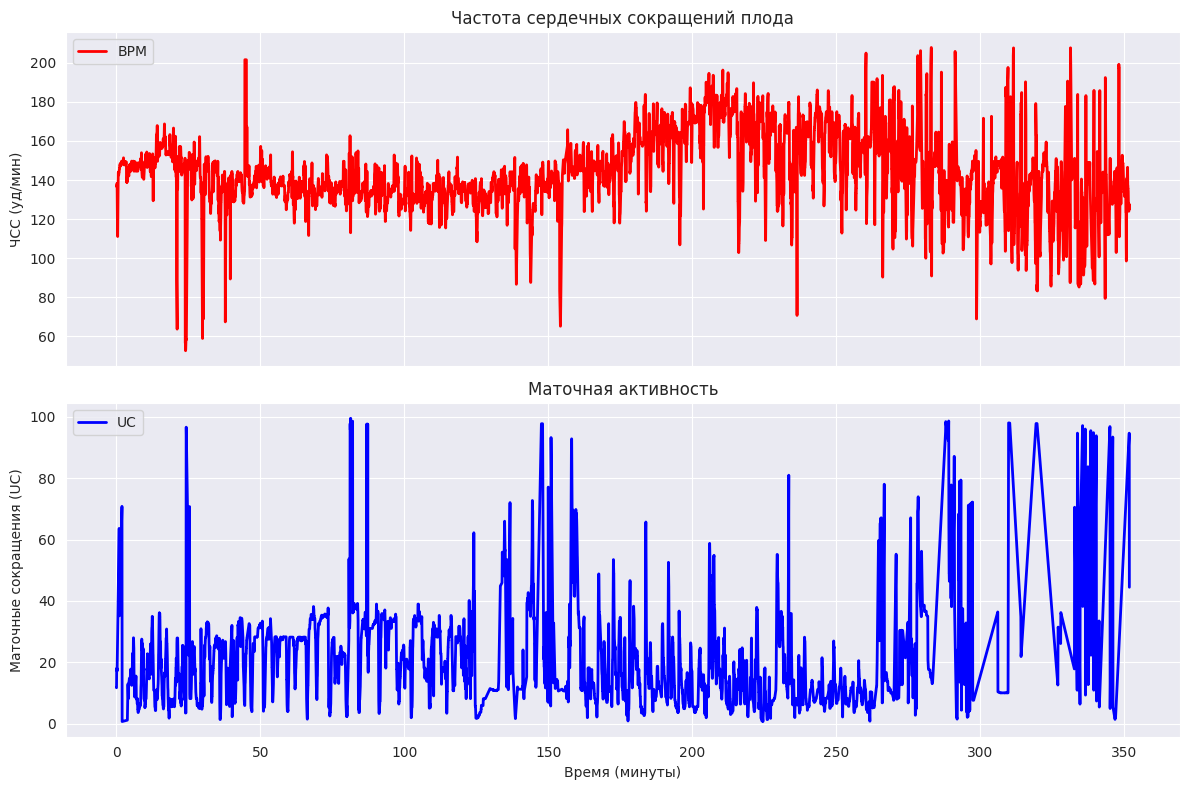

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

t_min = df_demo["t"] / 60

ax1.plot(t_min, df_demo["bpm"], "r-", linewidth=2, label="BPM")
ax1.set_ylabel("ЧСС (уд/мин)")
ax1.set_title("Частота сердечных сокращений плода")
ax1.legend()

ax2.plot(t_min, df_demo["uc"], "b-", linewidth=2, label="UC")
ax2.set_xlabel("Время (минуты)")
ax2.set_ylabel("Маточные сокращения (UC)")
ax2.set_title("Маточная активность")
ax2.legend()

plt.tight_layout()
plt.show()

## Детекция схваток

**Идея**: на основе сигнала UC с использованием пик-детекции найдём схватки и их характеристики.

### Шаги реализации:

- **Робастная статистика**: Используем медиану med и MAD для устойчивой оценки базового уровня и вариативности сигнала:
  ```
  med = median(UC)
  mad = median(|UC - med|)
  ```
- **Пороги**
    - **Минимальная выраженность (prominence)**: 
        `max(uc_prominence_min, uc_prominence_k_mad × mad)`
    - **Минимальная высота**: `med + uc_height_k_mad × mad`
    - **Минимальное расстояние между схватками**: `uc_min_distance_s × fs`

- **Детекция пиков**
-   Для каждого обнаруженного пика:
    1. **Локальный базовый уровень**: вычисляется как медиана в окне `±uc_local_base_window_s` вокруг пика
    2. **Уровень начала/окончания**: `base + uc_rel_start × h`, где `h` - высота пика над базой
    3. **Поиск границ**: линейный поиск влево и вправо до пересечения с уровнем

- **Валидация схваток**
    - **Минимальная длительность**: `duration ≥ uc_min_width_s`
    - **Положительная высота**: `h > 0`

In [12]:
def detect_contractions(df, p: Params = P):
    """
    Детектор схваток (UC):
      - ищем пики по prominence и высоте,
      - для каждого пика определяем start/end как точки пересечения с уровнем base+rel*h.
    """
    uc = df.uc.values
    t  = df.t.values

    # робастная статистика
    med = float(np.median(uc))
    mad = float(np.median(np.abs(uc - med)) + 1e-6)

    # пороги
    prom_abs = max(p.uc_prominence_min, p.uc_prominence_k_mad * mad)
    height_min = med + p.uc_height_k_mad * mad
    distance = int(p.uc_min_distance_s * p.fs)

    peaks, props = find_peaks(
        uc,
        prominence=prom_abs,
        height=height_min,
        distance=distance,
    )

    contractions = []
    # окно для поиска вокруг пика
    win = int(p.uc_local_base_window_s * p.fs)

    for pk, prom in zip(peaks, props["prominences"]):
        left = max(0, pk - win)
        right = min(len(uc), pk + win)
        local = np.r_[uc[left:pk-2], uc[pk+2:right]] if pk+2 < right and pk-2 > left else uc[left:right]
        # база
        base = float(np.median(local)) if len(local) > 0 else med

        peak_val = float(uc[pk])
        h = peak_val - base
        if h <= 0:
            continue

        level = base + p.uc_rel_start * h

        # влево
        i = pk
        while i > 0 and uc[i] > level:
            i -= 1
        start_idx = i

        # вправо
        j = pk
        while j < len(uc) - 1 and uc[j] > level:
            j += 1
        end_idx = j

        # если это были кратковременные схватки, тогда не учитывем
        duration = float(t[end_idx] - t[start_idx])
        if duration < p.uc_min_width_s:
            continue

        contractions.append(dict(
            start=float(t[start_idx]),
            peak=float(t[pk]),
            end=float(t[end_idx]),
            duration=float(t[end_idx] - t[start_idx]),
            height=float(h),
            base=base,
            prominence=float(prom),
        ))
    return contractions

In [13]:
def plot_contractions(df, contractions, t_start=0, t_end=None):
    if t_end is None:
        t_end = df.t.iloc[-1]

    mask = (df.t >= t_start) & (df.t <= t_end)
    seg = df.loc[mask]

    plt.figure(figsize=(12,5))
    plt.plot(seg.t/60, seg.uc, label="UC", color="black")

    for c in contractions:
        if c["end"] < t_start or c["start"] > t_end:
            continue

        plt.axvspan(c["start"]/60, c["end"]/60, color="grey", alpha=0.2)

        # точка пика
        idx_peak = np.argmin(np.abs(df.t - c["peak"]))
        plt.plot(c["peak"]/60, df.uc.iloc[idx_peak], "ro")

        plt.hlines(c["base"], xmin=c["start"]/60, xmax=c["end"]/60,
                   colors="blue", linestyles="dashed")

        plt.text(c["peak"]/60,
                 c["base"] + c["height"] + 3,
                 f'h={c["height"]:.1f}\npr={c["prominence"]:.1f}',
                 ha="center", va="bottom", fontsize=8, color="darkred")

    plt.xlabel("Время, мин")
    plt.ylabel("UC")
    plt.title("Детекция схваток: пики, baseline и проминенс")
    plt.legend()
    plt.show()

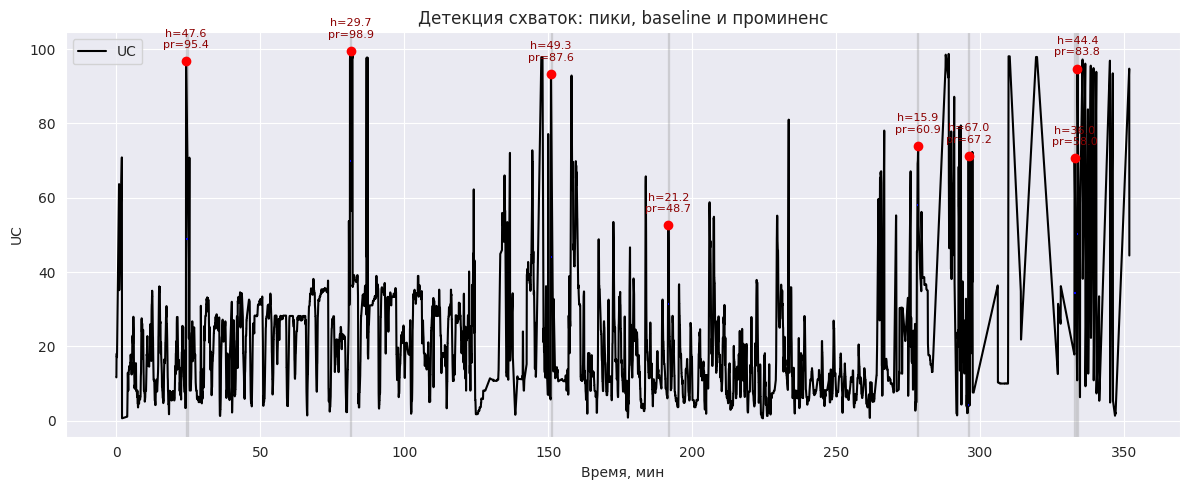

In [14]:
plot_contractions(df_demo, detect_contractions(df_demo))

In [15]:
def rolling_sd(x: np.ndarray, win_s: int) -> np.ndarray:
    """
    Скользящее стандартное отклонение (вариабельность FHR).
    win_s: длина окна в секундах
    fs: частота дискретизации (по умолчанию 1 Гц)
    """
    win = int(win_s * P.fs)
    return pd.Series(x).rolling(win, min_periods=win).std().values

def estimate_baseline_exp(bpm: np.ndarray, alpha=P.alpha) -> np.ndarray:
    """
    Экспоненциально сглаженный baseline FHR.
    Этот метод присваивает больший вес более последним наблюдениям,
    эффективно фильтруя кратковременные вариации (акселерации, децелерации) и выделяя долгосрочный тренд (базовый уровень).
    """
    base = np.zeros_like(bpm, dtype=float)
    base[0] = bpm[0]
    for i in range(1, len(bpm)):
        base[i] = alpha * bpm[i] + (1 - alpha) * base[i-1]
    return base

## Деселерации

**Идея**: на основе базовой линии ЧСС и обнаруженных схваток классифицируем деселерации по типам FIGO (early/late/variable/prolonged).  
Децелерация — временное замедление частоты сердечных сокращений (ЧСС) плода ниже базального уровня.  
На графике это впадины или провалы на линии сердцебиения (FHR).

### Шаги реализации:

- **Базовый уровень ЧСС**: вычисляем экспоненциально сглаженную baseline:
  ```
  base[i] = α × fhr[i] + (1-α) × base[i-1]
  ```

- **Поиск эпизодов падения ЧСС**:
  - **Порог падения**: `fhr ≤ base - decel_min_drop_bpm`
  - **Сегментация**: находим непрерывные интервалы ниже порога
  - **Фильтрация по длительности**: `duration ≥ decel_min_duration_s`

- **Анализ каждой деселерации**:
  - **Надир**: точка минимального значения ЧСС в эпизоде
  - **Глубина падения**: `drop = base[nadir] - fhr[nadir]`
  - **Проверка минимального падения**: `drop ≥ decel_min_drop_bpm`

- **Классификация типа**:
  - **Prolonged**: `duration ≥ prolonged_decel_min_s`
  - **Связь со схватками**: поиск максимального пересечения по времени
  - **Early**: начало вместе со схваткой, надир совпадает с пиком схватки (±10 сек)
  - **Late**: надир после пика схватки, окончание после окончания схватки
  - **Variable**: все остальные случаи (часто связаны с компрессией пуповины)

In [16]:
def detect_decelerations(df: pd.DataFrame, contractions, p: Params = P):
    """
    Возвращает список деселераций с типом FIGO.
    """
    t = df.t.values
    fhr = df.bpm.values
    # базовый уровень
    base = estimate_baseline_exp(fhr)

    # всё что ниже базового уровня - порог
    below = (fhr <= (base - p.decel_min_drop_bpm)).astype(int)
    labels, n = label(below)
    decels = []

    for k in range(1, n+1):
        idx = np.where(labels == k)[0]
        seg_t = t[idx]
        seg_f = fhr[idx]
        dur_s = seg_t[-1] - seg_t[0]

        # кратковременные выбросы не учитывем
        if dur_s < p.decel_min_duration_s:
            continue

        # надир и падание
        nadir_i = idx[np.argmin(seg_f)]
        drop = float(base[nadir_i] - fhr[nadir_i])
    
        if drop < p.decel_min_drop_bpm:
            continue

        # по умолчанию (нестрашно)
        dec_type, uc_idx, lag_to_uc_peak = "variable", None, None

        if dur_s >= p.prolonged_decel_min_s:
            dec_type = "prolonged"
        else:
            # ищем пересечение со схватками
            uc_idx, max_overlap = None, 0.0
            for idx_uc, uc in enumerate(contractions):
                ovl = max(0.0, min(seg_t[-1], uc["end"]) - max(seg_t[0], uc["start"]))
                if ovl > max_overlap:
                    max_overlap, uc_idx = ovl, idx_uc

            if uc_idx is not None and max_overlap > 0:
                uc = contractions[uc_idx]
                lag_to_uc_peak = float(t[nadir_i] - uc["peak"])

                near_peak = abs(lag_to_uc_peak) <= 10.0
                ends_after_uc = t[idx[-1]] > uc["end"]
                starts_with_uc = t[idx[0]] >= uc["start"] - 5.0

                if near_peak and starts_with_uc and not ends_after_uc:
                    dec_type = "early"
                elif lag_to_uc_peak > 0 and ends_after_uc:
                    dec_type = "late"

        decels.append(dict(
            start=float(seg_t[0]),
            nadir=float(t[nadir_i]),
            end=float(seg_t[-1]),
            drop_bpm=drop,
            duration_s=dur_s,
            type=dec_type,
            uc_idx=uc_idx,
            lag_to_uc_peak_s=lag_to_uc_peak
        ))
    return decels

In [17]:
def plot_decelerations(df: pd.DataFrame, contractions, decels,
                       t_start=0, t_end=None):
    if t_end is None:
        t_end = df.t.iloc[-1]

    mask = (df.t >= t_start) & (df.t <= t_end)
    seg = df.loc[mask].reset_index(drop=True)

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(seg.t/60, seg.bpm, color="black", label="FHR")
    ax1.set_ylabel("FHR (bpm)")
    ax1.set_xlabel("Время (мин)")

    # UC ось 2
    ax2 = ax1.twinx()
    ax2.plot(seg.t/60, seg.uc, color="grey", alpha=0.4, label="UC")
    ax2.set_ylabel("UC")

    # схватки
    for c in contractions:
        if c["end"] < t_start or c["start"] > t_end:
            continue
        ax2.axvspan(c["start"]/60, c["end"]/60, color="grey", alpha=0.15)

    # цвета для разных типов деселераций
    cmap = {
        "early": "green",
        "late": "red",
        "variable": "orange",
        "prolonged": "purple"
    }

    # деселерации
    for d in decels:
        if d["end"] < t_start or d["start"] > t_end:
            continue
        c = cmap.get(d["type"], "blue")

        ax1.axvspan(d["start"]/60, d["end"]/60, color=c, alpha=0.25,
                    label=d["type"] if d["type"] not in [l.get_label() for l in ax1.patches] else "")

        # точка надира
        idx_nadir = np.argmin(np.abs(df.t - d["nadir"]))
        ax1.plot(d["nadir"]/60, df.bpm.iloc[idx_nadir], "o", color=c)

    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.title("Деселерации (цветные зоны) и схватки (серые зоны)")
    plt.show()

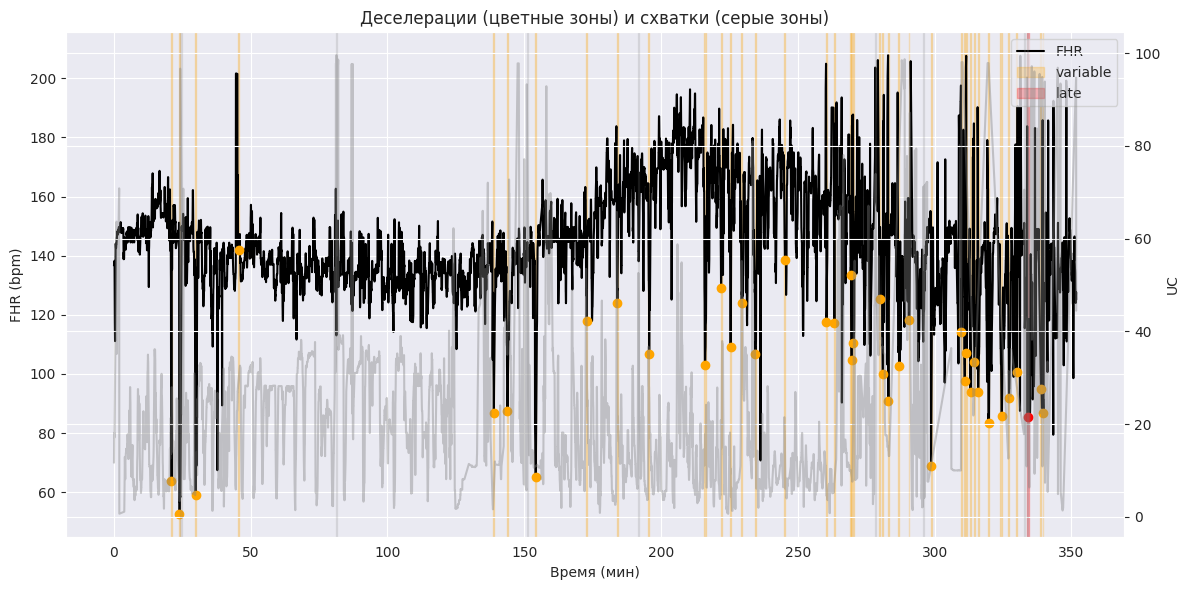

In [18]:
cons = detect_contractions(df_demo, P)
decels = detect_decelerations(df_demo, cons, P)
plot_decelerations(df_demo, cons, decels)

## Акцелераций

**Идея**: обнаружение акцелераций - временных повышений ЧСС плода относительно базовой линии, связанных с двигательной активностью плода или другими физиологическими процессами.

### Шаги реализации:

- **Базовый уровень ЧСС**: вычисляем экспоненциально сглаженную baseline:
  ```
  base[i] = α × fhr[i] + (1-α) × base[i-1]
  ```

- **Поиск эпизодов повышения ЧСС**:
  - **Порог акцелерации**: `fhr ≥ base + accel_min_rise_bpm`
  - **Сегментация**: находим непрерывные интервалы выше порога
  - **Фильтрация по длительности**: `duration ≥ accel_min_duration_s`

- **Анализ каждой акцелерации**:
  - **Пик**: точка максимального значения ЧСС в эпизоде
  - **Амплитуда подъема**: `rise_bpm = fhr[peak] - base[peak]`
  - **Длительность**: от начала до окончания эпизода

**Критерии акцелераций (FIGO)**:
- **Минимальный подъем**: `accel_min_rise_bpm = 15.0` (≥15 уд/мин над baseline)
- **Минимальная длительность**: `accel_min_duration_s = 15.0` (≥15 секунд)
- **Пик**: определяется как максимальное значение ЧСС в пределах акцелерации

**Физиологическая значимость**:
- Наличие акцелераций свидетельствует о нормальной реактивности вегетативной нервной системы плода
- Отсутствие акцелераций может указывать на угнетение состояния плода
- Акцелерации часто ассоциированы с движениями плода

In [19]:
def detect_accelerations(df, p: Params = P):
    """
    Поиск акцелераций:
    - ≥ accel_min_rise_bpm над baseline
    - длительность ≥ accel_min_duration_s
    """
    t = df.t.values
    fhr = df.bpm.values
    # база
    base = estimate_baseline_exp(fhr)

    # маска выше baseline
    above = (fhr >= (base + p.accel_min_rise_bpm)).astype(int)
    labels, n = label(above)

    accels = []
    for k in range(1, n+1):
        idx = np.where(labels == k)[0]
        seg_t = t[idx]
        seg_f = fhr[idx]
        duration_s = seg_t[-1] - seg_t[0]

        # короткие не учитываем
        if duration_s < p.accel_min_duration_s:
            continue

        peak_i_rel = int(np.argmax(seg_f))
        peak_i = idx[peak_i_rel]

        accels.append(dict(
            start=float(seg_t[0]),
            peak=float(t[peak_i]),
            end=float(seg_t[-1]),
            rise_bpm=float(fhr[peak_i] - base[peak_i]),
            duration_s=duration_s
        ))

    return accels


In [20]:
def plot_accelerations(df, accels, t_start=0, t_end=None):
    if t_end is None:
        t_end = df.t.iloc[-1]

    mask = (df.t >= t_start) & (df.t <= t_end)
    seg = df.loc[mask].reset_index(drop=True)

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(seg.t/60, seg.bpm, color="black", label="FHR")
    ax1.set_ylabel("FHR (bpm)")
    ax1.set_xlabel("Время (мин)")

    # UC ось 2
    ax2 = ax1.twinx()
    ax2.plot(seg.t/60, seg.uc, color="grey", alpha=0.4, label="UC")
    ax2.set_ylabel("UC")

    # акцелерации
    for a in accels:
        if a["end"] < t_start or a["start"] > t_end:
            continue

        ax1.axvspan(a["start"]/60, a["end"]/60, color="green", alpha=0.25)

        # найти индекс пика по времени
        idx_peak = np.argmin(np.abs(df.t - a["peak"]))
        ax1.plot(a["peak"]/60, df.bpm.iloc[idx_peak], "o", color="green")

        # подпись: амплитуда и длительность
        ax1.text(a["peak"]/60,
                 df.bpm.iloc[idx_peak] + 5,
                 f'+{a["rise_bpm"]:.0f} bpm\n{a["duration_s"]:.0f}s',
                 ha="center", va="bottom", fontsize=8, color="green")

    plt.title("Акцелерации (зелёные зоны) и UC (серая линия)")
    plt.show()

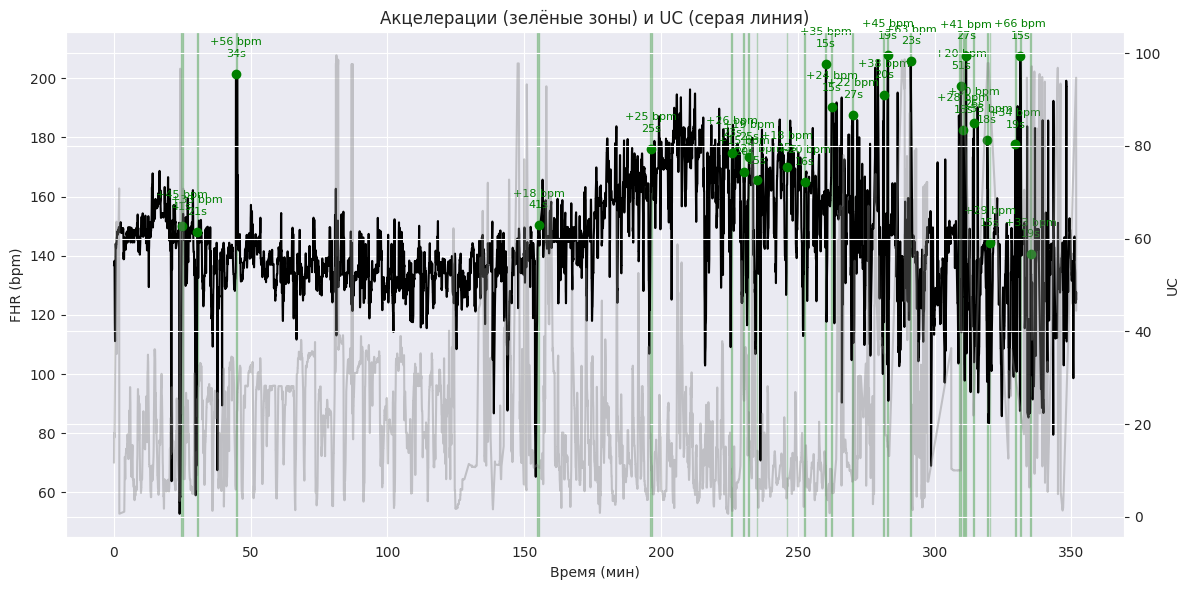

In [21]:
accels = detect_accelerations(df_demo)
plot_accelerations(df_demo, accels)

In [22]:
def summarize_events_on_window(seg: pd.DataFrame, p: Params = P) -> dict:
    fs = p.fs

    # UC и схватки
    cons = detect_contractions(seg, p)

    # Деселерации и акцелерации
    decels = detect_decelerations(seg, cons, p)
    accels = detect_accelerations(seg, p)

    # Вариабельность
    fhr = seg.bpm.values
    var_sd = float(np.nanstd(fhr))

    # низкая вариабельность: доля времени, где SD < 5 bpm (по окну 60с)
    sd_series = rolling_sd(fhr, win_s=60)
    if np.isfinite(sd_series).sum() > 0:
        low_var_ratio = float(np.mean(sd_series < p.low_var_bpm))
        low_var_mean  = float(np.nanmean(sd_series))
    else:
        low_var_ratio, low_var_mean = np.nan, np.nan

    # тахикардия / брадикардия
    tachy_ratio = float(np.mean(fhr > p.tachy_bpm))
    brady_ratio = float(np.mean(fhr < p.brady_bpm))

    counts = dict(
        cons_total      = len(cons),
        decel_total     = len(decels),
        decel_early     = sum(1 for d in decels if d["type"] == "early"),
        decel_late      = sum(1 for d in decels if d["type"] == "late"),
        decel_variable  = sum(1 for d in decels if d["type"] == "variable"),
        decel_prolonged = sum(1 for d in decels if d["type"] == "prolonged"),
        accel_total     = len(accels),
        contractions    = len(cons),
        low_var_ratio   = low_var_ratio,
        low_var_mean    = low_var_mean,
        sd_overall      = var_sd,
        tachy_ratio     = tachy_ratio,
        brady_ratio     = brady_ratio,
    )
    return counts, cons, decels, accels

## Сурогатный таргет по правилу FIGO


- **Пролонгированная деселерация** = падение ЧСС на ≥15 bpm, продолжающееся ≥2 минуты (120 с).
В FIGO это всегда считается патологическим событием, даже если оно случилось один раз.

- **Поздняя деселерация** = падение ЧСС, начинающееся после пика схватки и заканчивающееся после окончания схватки → маркер гипоксии.
В FIGO считается подозрительным, если повторяются; при ≥2 в пределах окна — высокий риск.

- **Низкая вариабельность** = сглаженная линия FHR, ребёнок не «реагирует».
В FIGO: «сниженная вариабельность >40 мин» считается патологией; у нас адаптировано под окно (например, 10 мин).  

- **Тахикардия** = baseline >160 bpm.  
- **Брадикардия** = baseline <110 bpm.

- **Отсутсвие акцелераций** - свидетельствует об аномалиях в поведении плода.

   
Если треть времени и больше ЧСС ребёнка в экстремальных зонах → это клинически значимо.


Всё вместе даёт бинарное правило:

* **1 (плохой прогноз):** если в окне была хотя бы одна пролонгированная деселерация, или ≥2 поздних деселерации, или низкая вариабельность большую часть времени, или тахи/бради ≥30% окна.
* **0 (норма/сомнительно):** если ничего из этого не наблюдается.


In [23]:
def future_rule_figo_like(seg_future: pd.DataFrame, p: Params = P) -> int:
    counts, cons, decels, accels = summarize_events_on_window(seg_future, p)

    # условия
    cond_prolonged   = counts["decel_prolonged"] >= 1
    cond_late        = counts["decel_late"] >= getattr(p, "late_decel_threshold", 2)
    cond_lowvar      = np.isfinite(counts["low_var_ratio"]) and counts["low_var_ratio"] >= getattr(p, "lowvar_ratio_threshold", 0.6)
    cond_hr_extreme  = (counts["tachy_ratio"] >= getattr(p, "tachy_brady_ratio_threshold", 0.3)) \
                       or (counts["brady_ratio"] >= getattr(p, "tachy_brady_ratio_threshold", 0.3))
    
    cond_accel_ok = counts["accel_total"] >= getattr(p, "accel_total_threshold", 2)

    if cond_accel_ok  and not (cond_prolonged or cond_late or cond_lowvar or cond_hr_extreme):
        return 0

    # бинарная метка
    label = int(cond_prolonged or cond_late or cond_lowvar or cond_hr_extreme)
    return label


## Общие признаки

In [24]:
def baseline_bpm(x: np.ndarray) -> float:
    """Глобальный baseline (медиана)"""
    return float(np.nanmedian(x))


def variability_features(bpm: np.ndarray) -> dict:
    """Статистические признаки вариабельности"""
    f = {}
    f["bpm_sd"]  = float(np.nanstd(bpm))
    f["bpm_iqr"] = float(np.nanpercentile(bpm, 75) - np.nanpercentile(bpm, 25))
    sec = bpm[::int(P.fs)] if P.fs >= 1 else bpm
    if len(sec) > 1 and np.isfinite(sec).sum() > 1:
        f["stv"] = float(np.nanmean(np.abs(np.diff(sec))))
    else:
        f["stv"] = np.nan
    return f


def psd_features(bpm: np.ndarray) -> dict:
    """Спектральные признаки HRV (low/high frequency)"""
    f = {}
    detr = bpm - np.nanmedian(bpm)
    if len(detr) >= P.fs*60:
        freqs, Pxx = welch(detr, fs=P.fs, nperseg=int(P.fs*60))
        lf_mask = (freqs >= 0.04) & (freqs < 0.15)
        hf_mask = (freqs >= 0.15) & (freqs < 0.4)
        f["psd_low"]  = float(Pxx[lf_mask].sum())
        f["psd_high"] = float(Pxx[hf_mask].sum())
        f["psd_lf_hf"] = float(f["psd_low"] / f["psd_high"]) if f["psd_high"] > 0 else np.nan
    else:
        f["psd_low"] = f["psd_high"] = f["psd_lf_hf"] = np.nan
    return f

def coupling_features(bpm: np.ndarray, uc: np.ndarray) -> dict:
    """Кросс-коррелиция: анализ взаимосвязи между двумя сигналами (FHR и UC)"""
    b0 = (bpm - np.nanmean(bpm)) / (np.nanstd(bpm) + 1e-6)
    u0 = (uc - np.nanmean(uc)) / (np.nanstd(uc) + 1e-6)
    xcorr = np.correlate(b0, u0, mode="full") / len(b0)
    return {"xcorr_absmax": float(np.nanmax(np.abs(xcorr))) if len(xcorr) else np.nan}

In [25]:
def compute_window_basic_features(seg: pd.DataFrame) -> dict:
    bpm = seg.bpm.values
    uc  = seg.uc.values
    feats = {}
    feats["baseline"] = baseline_bpm(bpm)
    feats.update(variability_features(bpm))
    feats.update(psd_features(bpm))
    feats.update(coupling_features(bpm, uc))
    return feats

## Дополнительные призанки для повышения устойчивости модели.

**Робастная статистика и тренды**

* `bpm_mad` — медианное абсолютное отклонение (менее чувствительно к выбросам, чем SD).
* `bpm_skew`, `bpm_kurt` — асимметрия и эксцесс.
* `trend_slope`, `trend_r2` — линейный тренд и его «объясняющая сила» (R²) в окне.
* `deriv_zero_cross_rate` — частота смены направления (по производной).
* `outlier_ratio` — доля выбросов по robust z-score (>|3| от медианы/MAD).

**Нелинейка / HRV**

* `rmssd` — кратковременная вариабельность (аналог HRV).
* `poincare_sd1`, `poincare_sd2`, `sd1_sd2_ratio` — короткая/длинная вариабельность.
* `perm_entropy` — пермутационная энтропия (локальная сложность).
* `samp_entropy` — выборочная энтропия (регулярность/«шумность»).
* `hjorth_activity`, `hjorth_mobility`, `hjorth_complexity` — компактные динамические индикаторы.

**Автокорреляция/регулярность**

* `ac_peak_lag`, `ac_decay_time` — лаг первого автокорреляционного пика и время затухания до 1/e.
* `dfa_alpha1`, `dfa_alpha2` — фрактальная корреляционная структура.

In [26]:
# Робастная статистика и тренд
def robust_stats(x):
    x = np.asarray(x)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) * 1.4826  # нормированный MAD
    skews = skew(x, nan_policy="omit")
    kurt = kurtosis(x, fisher=True, nan_policy="omit")
    # robust z
    rz = (x - med) / (mad + 1e-9)
    outlier_ratio = np.mean(np.abs(rz) > 3) if np.isfinite(rz).any() else np.nan
    return {
        "bpm_mad": float(mad),
        "bpm_skew": float(skews),
        "bpm_kurt": float(kurt),
        "outlier_ratio": float(outlier_ratio),
    }

def trend_features(x, fs):
    t = np.arange(len(x)) / fs
    xm = np.nanmean(x); xs = x - xm
    # линейная регрессия по формуле нормальных уравнений
    A = np.vstack([t, np.ones_like(t)]).T
    coef, _, _, _ = np.linalg.lstsq(A, x, rcond=None)
    slope = coef[0]
    # R^2
    yhat = A @ coef
    ss_res = np.nansum((x - yhat)**2)
    ss_tot = np.nansum((x - np.nanmean(x))**2) + 1e-12
    r2 = 1.0 - ss_res/ss_tot
    # частота смены направления (по производной)
    dx = np.diff(x)
    zcr = np.mean(dx[:-1] * dx[1:] < 0) if len(dx) > 2 else np.nan
    return {
        "trend_slope": float(slope),
        "trend_r2": float(r2),
        "deriv_zero_cross_rate": float(zcr),
    }

# HRV / нелинейка
def rmssd(x):
    d = np.diff(x)
    return float(np.sqrt(np.nanmean(d*d)))

def poincare_sd1_sd2(x):
    x1, x2 = x[:-1], x[1:]
    dif = x2 - x1
    sd1 = np.sqrt(np.nanvar(dif) / 2.0)
    sd2 = np.sqrt(2*np.nanvar(x) - (np.nanvar(dif)/2.0))
    return float(sd1), float(sd2), float(sd1/(sd2+1e-9))

def permutation_entropy(x, m=3, tau=1):
    # простая реализация PE
    x = np.asarray(x)
    n = len(x) - (m-1)*tau
    if n <= 0:
        return np.nan
    patterns = {}
    for i in range(n):
        pat = tuple(np.argsort(x[i:i+m*tau:tau]))
        patterns[pat] = patterns.get(pat, 0) + 1
    p = np.array(list(patterns.values()), dtype=float)
    p /= p.sum()
    H = -np.sum(p*np.log2(p))
    Hmax = np.log2(math.factorial(m))
    return float(H / (Hmax + 1e-12))

def hjorth_params(x, fs):
    x = np.asarray(x)
    dx = np.diff(x, prepend=x[0]) * fs
    ddx = np.diff(dx, prepend=dx[0]) * fs
    var_x = np.nanvar(x); var_dx = np.nanvar(dx); var_ddx = np.nanvar(ddx)
    activity = var_x
    mobility = np.sqrt(var_dx/(var_x+1e-12))
    complexity = np.sqrt(var_ddx/(var_dx+1e-12)) / (mobility + 1e-12)
    return float(activity), float(mobility), float(complexity)

# Автокорреляция
def autocorr_features(x, fs, max_lag_s=120):
    x = np.asarray(x) - np.nanmean(x)
    x = np.nan_to_num(x)
    n = len(x)
    max_lag = int(max_lag_s*fs)
    ac = correlate(x, x, mode="full")[n-1:n+max_lag]
    ac /= ac[0] + 1e-12
    # первый локальный пик после нулевого лага
    # найдём максимум на интервале [1..]
    if len(ac) > 2:
        # грубо: лаг, где ac максимален после нуля
        lag_idx = 1 + np.argmax(ac[1:])
        ac_peak_lag = lag_idx / fs
    else:
        ac_peak_lag = np.nan
    # время спада до уровня 1/e
    below = np.where(ac <= (1/np.e))[0]
    ac_decay = (below[0]/fs) if len(below) > 0 else np.nan
    return float(ac_peak_lag), float(ac_decay)

In [27]:
def compute_window_extra_features(fhr, fs):
    feats = {}
    feats.update(robust_stats(fhr))
    feats.update(trend_features(fhr, fs))
    sd1, sd2, ratio = poincare_sd1_sd2(fhr)
    feats.update({
        "rmssd": rmssd(fhr),
        "poincare_sd1": sd1,
        "poincare_sd2": sd2,
        "sd1_sd2_ratio": ratio,
        "perm_entropy": permutation_entropy(fhr, m=3, tau=max(1, int(0.5*fs))),  # ~0.5с лаг
    })
    act, mob, comp = hjorth_params(fhr, fs)
    feats.update({
        "hjorth_activity": act,
        "hjorth_mobility": mob,
        "hjorth_complexity": comp,
    })
    ac_lag, ac_decay = autocorr_features(fhr, fs)
    feats.update({
        "ac_peak_lag": ac_lag,
        "ac_decay_time": ac_decay,
    })
    return feats

In [28]:
def compute_window_features_with_events(seg: pd.DataFrame, p: Params = P) -> dict:
    # базовые агрегаты
    base_feats = compute_window_basic_features(seg)

    # события по FIGO
    counts, cons, decels, accels = summarize_events_on_window(seg, p)
    base_feats.update({f"evt_{k}": v for k, v in counts.items()})

    # дополнительные динамические и спектральные признаки
    extra_feats = compute_window_extra_features(seg.bpm.values, P.fs)
    base_feats.update({f"extra_{k}": v for k, v in extra_feats.items()})

    # # лаги поздних деселераций
    # lags = [d["lag_to_uc_peak_s"] for d in decels if d["type"] == "late" and d["lag_to_uc_peak_s"] is not None]
    # base_feats["evt_late_mean_lag_s"] = float(np.mean(lags)) if lags else 0.0
    # base_feats["evt_late_max_lag_s"]  = float(np.max(lags)) if lags else 0.0

    # глубина деселераций и высота акцелераций
    drops = [d["drop_bpm"] for d in decels]
    rises = [a["rise_bpm"] for a in accels]
    base_feats["evt_decel_mean_drop"] = float(np.mean(drops)) if drops else 0.0
    base_feats["evt_accel_mean_rise"] = float(np.mean(rises)) if rises else 0.0

    return base_feats


## Создание окон и фич по ним

In [29]:
@dataclass 
class WindowSpec: 
    W_min: int = 5 # ширина истории, минут 
    H_min: int = 5 # горизонт прогноза, минут 
    stride_s: int = 1

def build_windows_for_case_with_events(df: pd.DataFrame,
                                       label_func,
                                       w: WindowSpec,
                                       p: Params = P,
                                       case_id=None):
    W = int(w.W_min*60*p.fs)
    H = int(w.H_min*60*p.fs)
    S = int(w.stride_s*p.fs)

    if len(df) < W + H:
        if len(df) >= W + int(0.5*H):
            H = len(df) - W
            print(f"[WARN] запись короткая, горизонт урезан до {H/p.fs:.1f}с")
        else:
            return pd.DataFrame(), np.array([]), np.array([])

    rows, labels, tmarks = [], [], []
    for start in range(0, len(df) - (W + H) + 1, S):
        seg_hist = df.iloc[start : start + W]
        seg_fut  = df.iloc[start + W : start + W + H]

        feats = compute_window_features_with_events(seg_hist, p)
        rows.append(feats)

        lbl = label_func(seg_fut)
        labels.append(int(lbl) if not isinstance(lbl, dict) else int(lbl["label"]))
        tmarks.append(df.t.iloc[start + W])

    X = pd.DataFrame(rows)
    y = np.asarray(labels, dtype=int)
    tmarks = np.asarray(tmarks)

    return X, y, tmarks

In [30]:
def build_dataset_for_dir(base_dir: str,
                          folder_ids,
                          meta_df: pd.DataFrame,
                          horizons=(5, 10, 15),
                          w_hist_min: int = 10,
                          label_func=None):
    all_X, all_y, all_groups = [], [], []

    if label_func is None:
        label_func = lambda seg: future_rule_figo_like(seg, P)

    for fid in folder_ids:
        try:
            df = load_case(os.path.join(base_dir, fid))
        except Exception as e:
            print(f"[WARN] Пропуск {fid}: {e}")
            continue

        for H in horizons:
            W = WindowSpec(W_min=w_hist_min, H_min=H, stride_s=30)
            X, y, _ = build_windows_for_case_with_events(df, label_func, w=W, p=P)

            if X.empty:
                print(f"[INFO] {fid}, H={H}: окон не сформировано")
                continue

            print(f"[INFO] {fid}, H={H}: {len(y)} окон, положительных={y.sum()}")

            X = X.assign(H=H, folder_id=fid)
            all_X.append(X)
            all_y.append(y)
            all_groups.extend([fid] * len(y))

    if not all_X:
        raise RuntimeError("Не удалось сформировать ни одного окна.")

    X = pd.concat(all_X, ignore_index=True)
    y = np.concatenate(all_y)
    groups = list(all_groups)

    # # джойним с мета-информацией
    # X = X.merge(meta_df, on="folder_id", how="left")

    return X, y, groups


In [31]:
folder_ids_regular = os.listdir(P.regular_dir)
folder_ids_hypoxia = os.listdir(P.hypoxia_dir)

In [32]:
X_reg, y_reg, groups_reg = build_dataset_for_dir(
    P.regular_dir,
    folder_ids_regular,
    pd.DataFrame(),
    horizons=(5, 10, ),
    w_hist_min=5
)

[INFO] 7, H=5: 629 окон, положительных=337
[INFO] 7, H=10: 619 окон, положительных=352
[INFO] 135, H=5: 92 окон, положительных=50
[INFO] 135, H=10: 82 окон, положительных=44
[INFO] 17, H=5: 27 окон, положительных=4
[INFO] 17, H=10: 17 окон, положительных=0
[INFO] 19, H=5: 157 окон, положительных=43
[INFO] 19, H=10: 147 окон, положительных=38
[INFO] 121, H=5: 107 окон, положительных=37
[INFO] 121, H=10: 97 окон, положительных=43
[INFO] 22, H=5: 291 окон, положительных=113
[INFO] 22, H=10: 281 окон, положительных=154
[INFO] 2, H=5: 36 окон, положительных=36
[INFO] 2, H=10: 26 окон, положительных=26
[INFO] 147, H=5: 606 окон, положительных=324
[INFO] 147, H=10: 596 окон, положительных=357
[INFO] 145, H=5: 305 окон, положительных=38
[INFO] 145, H=10: 295 окон, положительных=63
[INFO] 137, H=5: 85 окон, положительных=0
[INFO] 137, H=10: 75 окон, положительных=0
[INFO] 35, H=5: 96 окон, положительных=65
[INFO] 35, H=10: 86 окон, положительных=84
[INFO] 23, H=5: 48 окон, положительных=7
[INFO

In [33]:
X_hyp, y_hyp, groups_hyp = build_dataset_for_dir(
    P.hypoxia_dir,
    folder_ids_hypoxia,
    pd.DataFrame(),
    horizons=(5,10, ),
    w_hist_min=5
)

[INFO] 7, H=5: 92 окон, положительных=87
[INFO] 7, H=10: 82 окон, положительных=82
[INFO] 17, H=5: 145 окон, положительных=77
[INFO] 17, H=10: 135 окон, положительных=80
[INFO] 19, H=5: 137 окон, положительных=40
[INFO] 19, H=10: 127 окон, положительных=32
[INFO] 22, H=5: 193 окон, положительных=24
[INFO] 22, H=10: 183 окон, положительных=30
[INFO] 2, H=5: 23 окон, положительных=19
[INFO] 2, H=10: 13 окон, положительных=13
[INFO] 50, H=5: 620 окон, положительных=391
[INFO] 50, H=10: 610 окон, положительных=444
[INFO] 23, H=5: 62 окон, положительных=41
[INFO] 23, H=10: 52 окон, положительных=32
[INFO] 10, H=5: 818 окон, положительных=212
[INFO] 10, H=10: 808 окон, положительных=234
[INFO] 5, H=5: 374 окон, положительных=176
[INFO] 5, H=10: 364 окон, положительных=237
[INFO] 20, H=5: 680 окон, положительных=302
[INFO] 20, H=10: 670 окон, положительных=330
[INFO] 27, H=5: 51 окон, положительных=7
[INFO] 27, H=10: 41 окон, положительных=3
[INFO] 32, H=5: 759 окон, положительных=262
[INFO] 

In [34]:
X_reg["folder_id"] = "regular_" + X_reg["folder_id"].astype(str)

X_hyp["folder_id"] = "hypoxia_" + X_hyp["folder_id"].astype(str)

X_full = pd.concat([X_reg, X_hyp], ignore_index=True)
y_full = np.concatenate([y_reg, y_hyp])
groups_full = groups_hyp + groups_reg

print("X_full:", X_full.shape)
print("y_full:", y_full.shape)
print("groups:", len(groups_full))

print(pd.Series(y_full).value_counts())
X_full.head()

X_full: (61700, 42)
y_full: (61700,)
groups: 61700
0    30923
1    30777
Name: count, dtype: int64


,baseline,bpm_sd,bpm_iqr,stv,psd_low,psd_high,psd_lf_hf,xcorr_absmax,evt_cons_total,evt_decel_total,...,extra_perm_entropy,extra_hjorth_activity,extra_hjorth_mobility,extra_hjorth_complexity,extra_ac_peak_lag,extra_ac_decay_time,evt_decel_mean_drop,evt_accel_mean_rise,H,folder_id
0,137.124900,10.066500,11.623785,1.411856,1701.138483,93.370541,18.219221,0.416288,0,0,...,0.474499,101.334422,0.299497,3.469172,1.0,7.0,0.0,0.0,5,regular_7
1,138.066328,10.401783,14.176101,1.407116,1794.390205,100.722220,17.815237,0.453357,0,0,...,0.440250,108.197086,0.289214,3.583985,1.0,7.0,0.0,0.0,5,regular_7
2,139.294050,10.251671,13.488950,1.316091,1583.943112,99.040290,15.992917,0.606681,0,0,...,0.420623,105.096753,0.283297,3.710109,1.0,8.0,0.0,0.0,5,regular_7
3,139.346537,10.143372,11.568849,1.260343,1511.189319,87.271246,17.316005,0.599512,0,0,...,0.468222,102.887996,0.283566,3.709173,1.0,8.0,0.0,0.0,5,regular_7
4,140.322947,9.841081,10.015987,1.225494,1372.982085,84.068762,16.331656,0.565822,0,0,...,0.514702,96.846882,0.283093,3.616686,1.0,8.0,0.0,0.0,5,regular_7


## Preprocessing

In [35]:
def plot_feature_distributions(df: pd.DataFrame,
                               features: list[str],
                               group_col: str = "H",
                               bins: int = 20,
                               log_scale: bool = False):
    """
    Визуализация распределений признаков по группам (по горизонту прогноза H).
    """

    n_features = len(features)
    ncols = 3
    nrows = (n_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()

    for i, feat in enumerate(features):
        ax = axes[i]
        sns.histplot(
            data=df,
            x=feat,
            hue=group_col,
            bins=bins,
            common_norm=False,
            ax=ax,
            alpha=0.5
        )
        ax.set_title(feat)
        if log_scale:
            ax.set_xscale("log")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


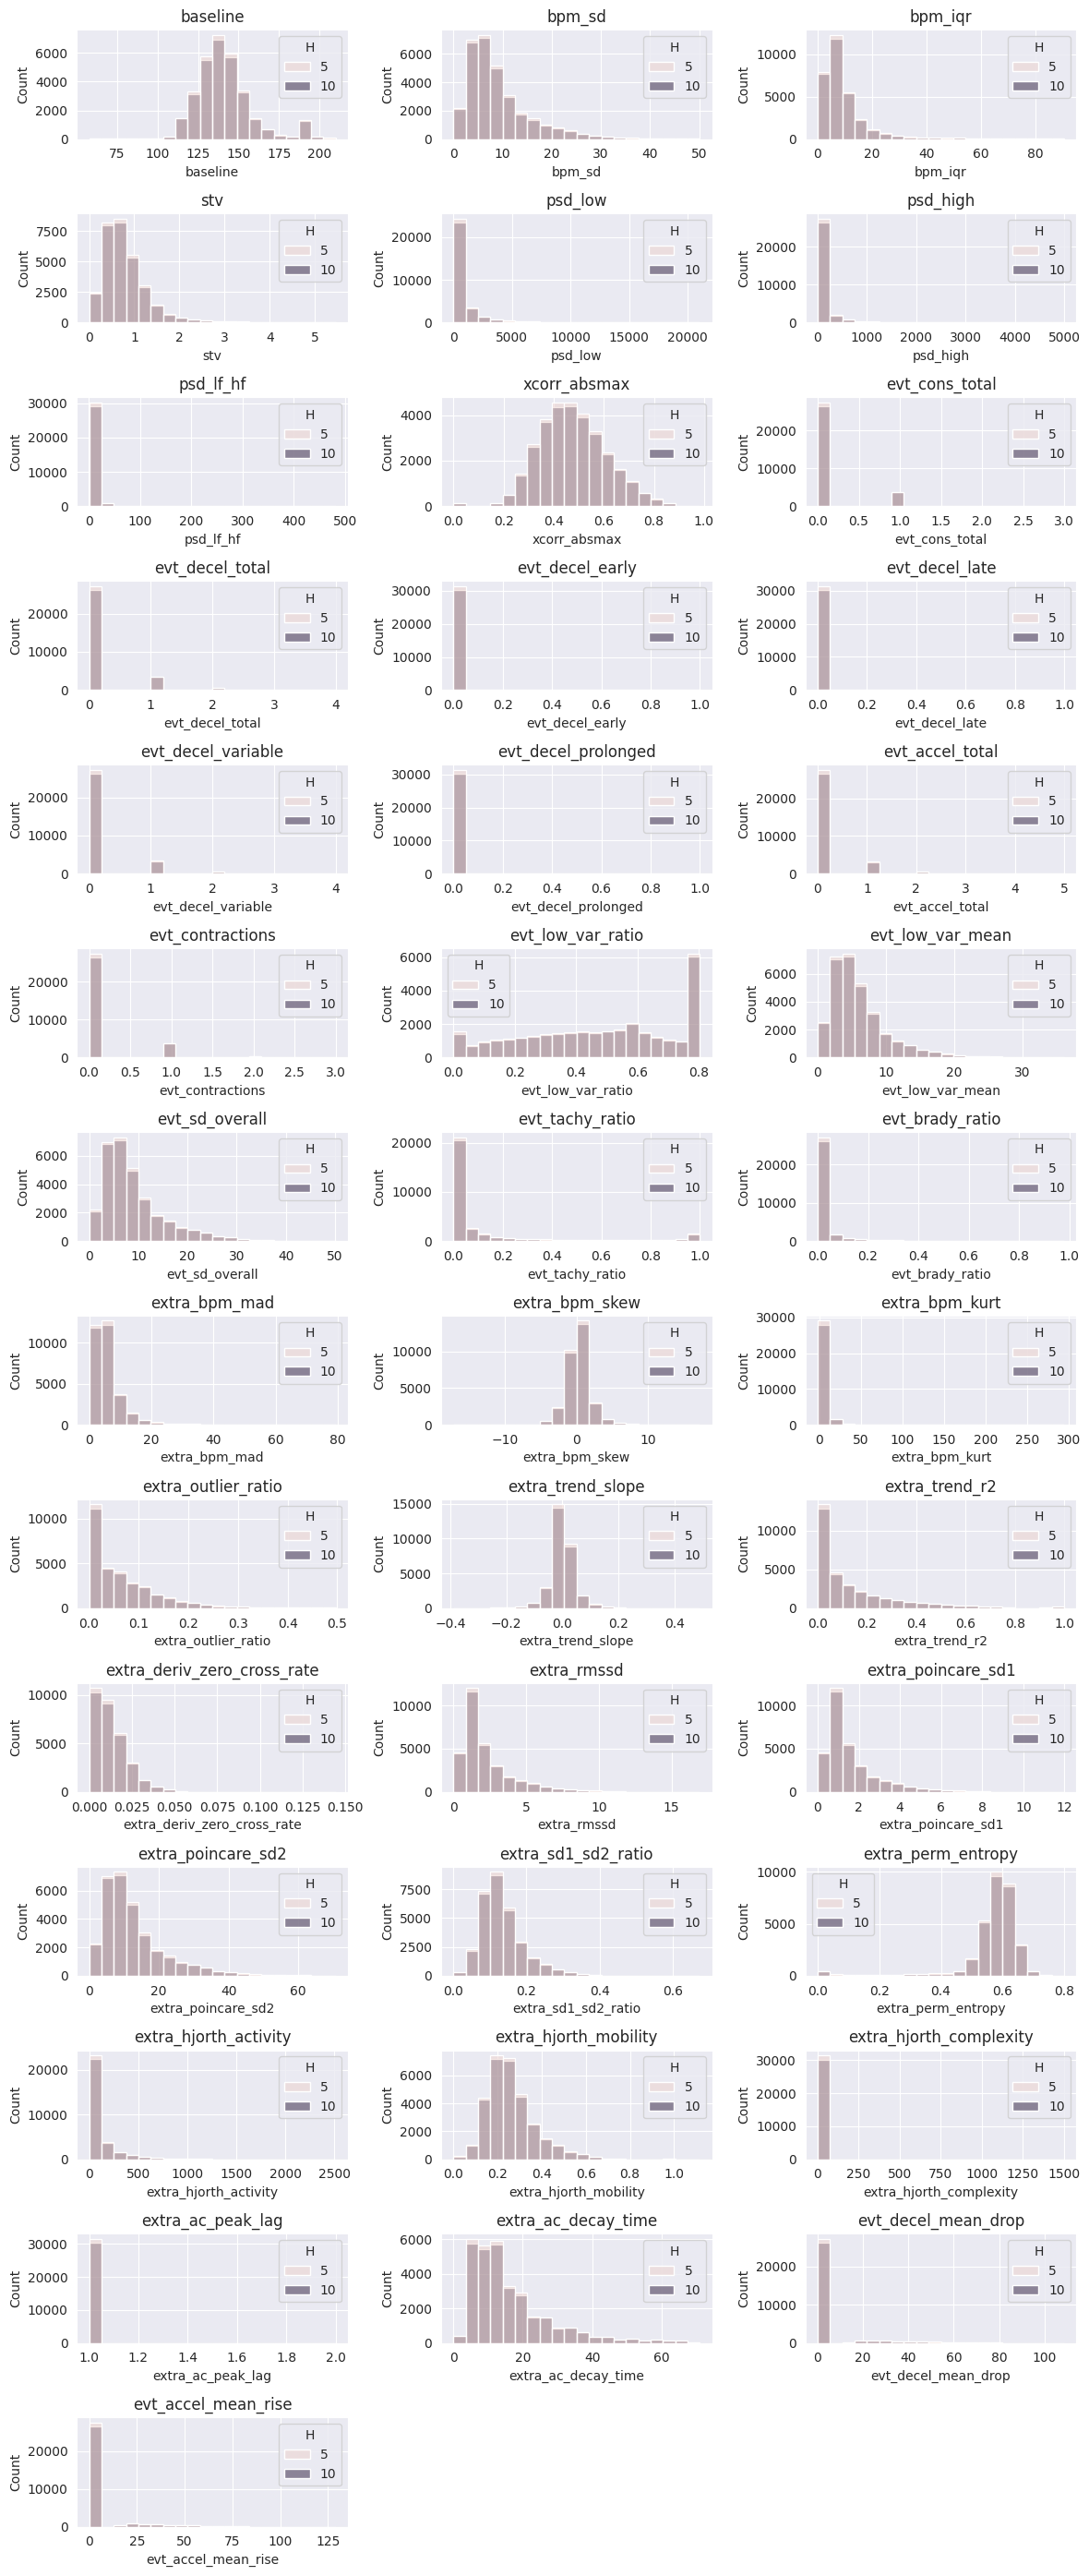

In [36]:
plot_feature_distributions(X_full, features=X_full.columns[:-2], group_col="H", bins=20)

In [32]:
log_scale_columns = [
    "bpm_sd", "bpm_iqr", "stv", "psd_low", "psd_high",
    "psd_lf_hf", "evt_low_var_mean", "evt_sd_overall",
    "evt_tachy_ratio", "evt_brady_ratio", "extra_bpm_mad",
    "extra_bpm_kurt", "extra_outlier_ratio", "extra_trend_r2", 
    "extra_deriv_zero_cross_rate", "extra_rmssd", "extra_poincare_sd1", 
    "extra_poincare_sd2", "extra_sd1_sd2_ratio", "extra_hjorth_activity", 
    "extra_hjorth_complexity", "extra_ac_peak_lag", "extra_ac_decay_time"
]
drop_columns = [
    "extra_hjorth_complexity",  "folder_id"
]

In [38]:
X_full.loc[:, log_scale_columns] = np.log1p(X_full.loc[:, log_scale_columns])

## Обучение модели
### По признакам в окне (каждая строка) → вероятность, что в следующем горизонте (H минут) наступит проблема (гипоксия / неблагоприятный FIGO-эпизод)

In [39]:
def plot_roc_curve(y_true, y_pred_probas):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
    
    auc_value = roc_auc_score(y_true, y_pred_probas)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:.4f}', lw=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


=== Fold 1 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7284350	best: 0.7284350 (0)	total: 957ms	remaining: 1h 3m 46s
200:	test: 0.7521325	best: 0.7526321 (142)	total: 12.5s	remaining: 3m 56s
400:	test: 0.7501496	best: 0.7526321 (142)	total: 24s	remaining: 3m 35s
bestTest = 0.7526320815
bestIteration = 142
Shrink model to first 143 iterations.


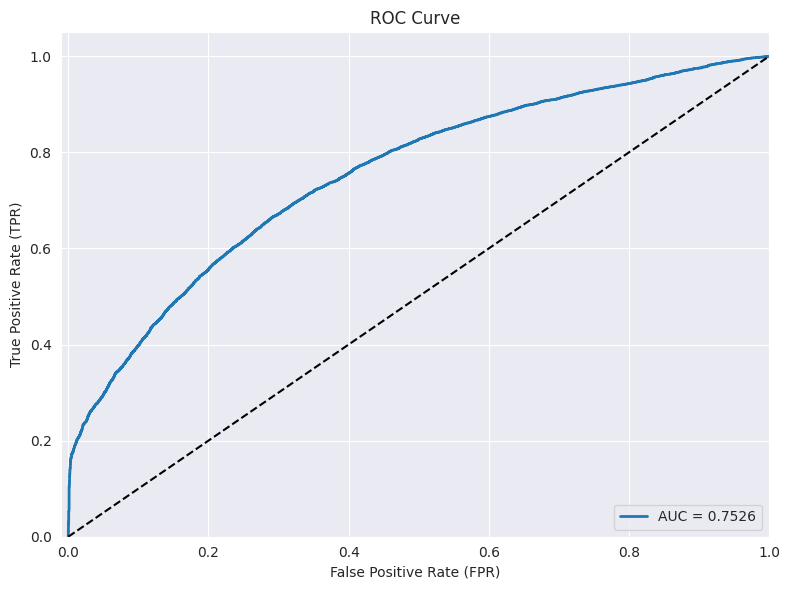

Fold 1: AUC=0.7526

=== Fold 2 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7122818	best: 0.7122818 (0)	total: 106ms	remaining: 7m 4s
200:	test: 0.7379123	best: 0.7385799 (183)	total: 11.8s	remaining: 3m 42s
400:	test: 0.7372309	best: 0.7385799 (183)	total: 23.3s	remaining: 3m 29s
bestTest = 0.7385798991
bestIteration = 183
Shrink model to first 184 iterations.


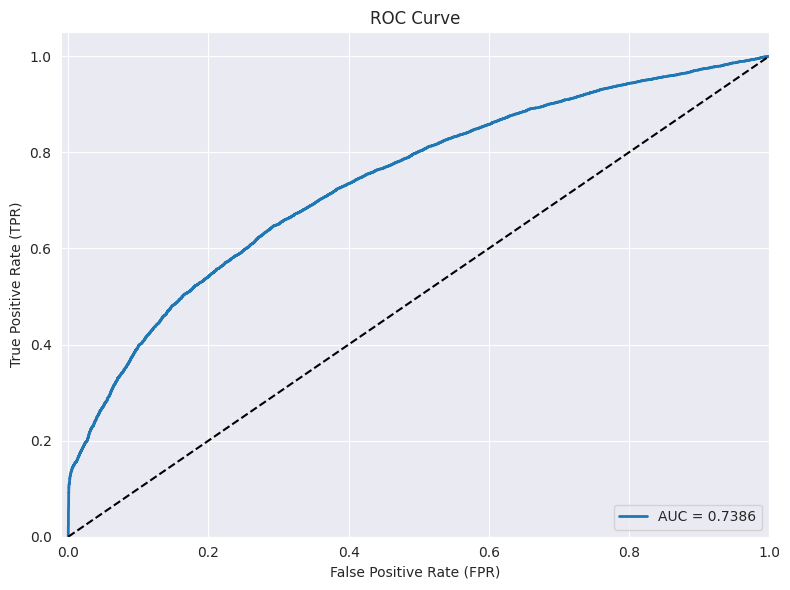

Fold 2: AUC=0.7386

=== Fold 3 ===


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7488071	best: 0.7488071 (0)	total: 59.3ms	remaining: 3m 57s
200:	test: 0.7627842	best: 0.7637525 (98)	total: 11.6s	remaining: 3m 39s
bestTest = 0.7637525201
bestIteration = 98
Shrink model to first 99 iterations.


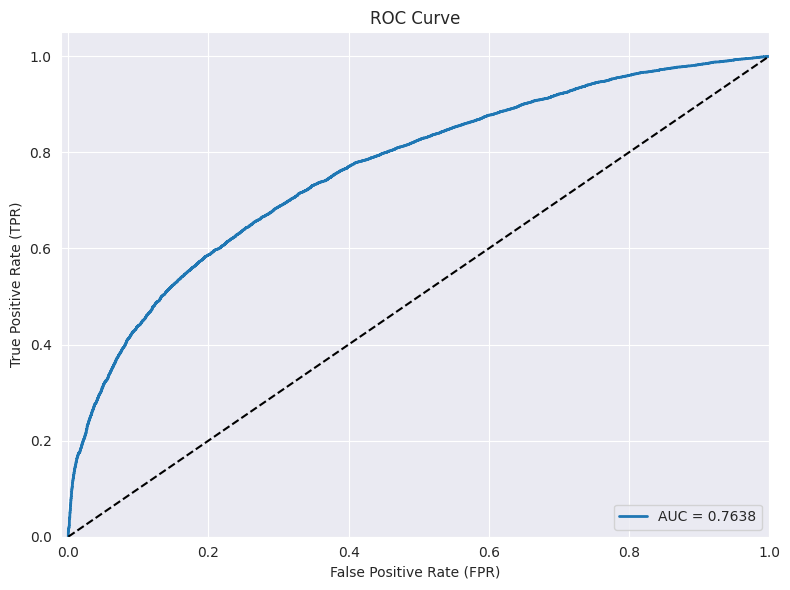

Fold 3: AUC=0.7638

Average AUC Score: 0.7517


In [40]:
X = X_full.drop(columns=drop_columns)
y = pd.Series(y_full)
groups = X_full["folder_id"]

gkf = GroupKFold(n_splits=3)

auc_scores = []

oof_proba = np.zeros(len(X))
oof_true = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n=== Fold {fold+1} ===")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_pool = Pool(X_train, y_train)
    val_pool   = Pool(X_val,   y_val)

    model = CatBoostClassifier(
        task_type="GPU",
        devices="0,1",
        loss_function="CrossEntropy",
        eval_metric="AUC",
        iterations=4000,
        learning_rate=0.03,
        depth=7,
        l2_leaf_reg=5.0,
        random_seed=42,
        bootstrap_type="Poisson",
        subsample=0.8,              # стохастичность = меньше переобучения
        border_count=254,           # число бинов для численных
        od_type="Iter",
        od_wait=300,
        use_best_model=True,
        verbose=200
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    oof_proba[val_idx] = y_pred_proba
    oof_true[val_idx] = y_val

    auc = roc_auc_score(y_val, y_pred_proba)
    plot_roc_curve(y_val, y_pred_proba)
    
    auc_scores.append(auc)
    
    print(f"Fold {fold + 1}: AUC={auc:.4f}")

print(f"\nAverage AUC Score: {np.mean(auc_scores):.4f}")

### Тюнинг

In [41]:
gkf = GroupKFold(n_splits=3)

def objective(trial):
    params = {
        "task_type": "GPU",
        "devices": "0,1",
        "loss_function": "CrossEntropy",
        "random_seed": P.seed,
        "use_best_model": True,
        "od_type": "Iter",
        "od_wait": trial.suggest_int("od_wait", 150, 400),
        "iterations": trial.suggest_int("iterations", 1500, 6000),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.06, log=True),
        "depth": trial.suggest_int("depth", 6, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 3.0, 15.0, log=True),
        "bootstrap_type": "Poisson",
        "subsample": trial.suggest_float("subsample", 0.70, 0.95),
        "border_count": trial.suggest_categorical("border_count", [128, 254]),
        "verbose": False,
        "allow_writing_files": False
    }

    aucs = []
    for tr_idx, va_idx in gkf.split(X, y, groups):
        train_pool = Pool(X.iloc[tr_idx], y.iloc[tr_idx])
        val_pool   = Pool(X.iloc[va_idx], y.iloc[va_idx])
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool)
        y_pred = model.predict_proba(val_pool)[:, 1]
        aucs.append(roc_auc_score(y.iloc[va_idx], y_pred))

    return float(np.mean(aucs))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=90, show_progress_bar=True)
print(study.best_value, study.best_params)

[I 2025-09-28 07:35:55,606] A new study created in memory with name: no-name-f1c04ec1-2542-47a5-ae63-b023d21061c3


  0%|          | 0/90 [00:00<?, ?it/s]

[I 2025-09-28 07:37:31,868] Trial 0 finished with value: 0.750395493953539 and parameters: {'od_wait': 313, 'iterations': 4862, 'learning_rate': 0.022267787918153856, 'depth': 7, 'l2_leaf_reg': 3.7095805451629413, 'subsample': 0.8224596361955784, 'border_count': 254}. Best is trial 0 with value: 0.750395493953539.
[I 2025-09-28 07:41:20,985] Trial 1 finished with value: 0.7503938941220502 and parameters: {'od_wait': 269, 'iterations': 5602, 'learning_rate': 0.02430424396645009, 'depth': 9, 'l2_leaf_reg': 4.576669945433725, 'subsample': 0.8262577512516929, 'border_count': 128}. Best is trial 0 with value: 0.750395493953539.
[I 2025-09-28 07:42:46,899] Trial 2 finished with value: 0.7514391809855351 and parameters: {'od_wait': 371, 'iterations': 2154, 'learning_rate': 0.04622127951506399, 'depth': 7, 'l2_leaf_reg': 4.962076280327352, 'subsample': 0.830827448923144, 'border_count': 128}. Best is trial 2 with value: 0.7514391809855351.
[I 2025-09-28 07:43:47,543] Trial 3 finished with valu

In [42]:
best_params = {
    "task_type": "GPU",
    "devices": "0,1",
    "loss_function": "CrossEntropy",
    "random_seed": P.seed,
    "verbose": 200,
    "od_type": "Iter",
    "bootstrap_type": "Poisson",
    **study.best_params
}

In [43]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=P.seed)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train_full, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train_full, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

gss_inner = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=P.seed+1)
tr_idx, val_idx = next(gss_inner.split(X_train_full, y_train_full, groups_train))

X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
y_tr, y_val = y_train_full.iloc[tr_idx], y_train_full.iloc[val_idx]

train_pool = Pool(X_tr.drop(columns=["folder_id"], errors="ignore"), y_tr)
val_pool   = Pool(X_val.drop(columns=["folder_id"], errors="ignore"), y_val)
test_pool  = Pool(X_test.drop(columns=["folder_id"], errors="ignore"), y_test)

model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=val_pool, verbose=False)

val_proba = model.predict_proba(val_pool)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

f1s = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1s[:-1]))
best_thr = float(thresholds[best_idx])

print(f"Best F1 on val: {f1s[best_idx]:.4f} at thr={best_thr:.3f}")

test_proba = model.predict_proba(test_pool)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

auc = roc_auc_score(y_test, test_proba)
f1  = f1_score(y_test, test_pred)

print(f"TEST AUC={auc:.4f}  TEST F1={f1:.4f}  (thr={best_thr:.3f})")

Best F1 on val: 0.6886 at thr=0.417
TEST AUC=0.7365  TEST F1=0.6917  (thr=0.417)


In [44]:
train_pool = Pool(X, y_full)

model = CatBoostClassifier(
    **best_params
)
model.fit(train_pool)

importances = model.get_feature_importance(train_pool, type="PredictionValuesChange")
feat_names = X.columns

imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

print(imp_df.head(20))

0:	learn: 0.6836961	total: 14.1ms	remaining: 51.8s
200:	learn: 0.5220739	total: 1.19s	remaining: 20.5s
400:	learn: 0.4802437	total: 2.4s	remaining: 19.5s
600:	learn: 0.4484549	total: 3.63s	remaining: 18.6s
800:	learn: 0.4226496	total: 4.88s	remaining: 17.5s
1000:	learn: 0.4010781	total: 6.1s	remaining: 16.3s
1200:	learn: 0.3823267	total: 7.32s	remaining: 15s
1400:	learn: 0.3651878	total: 8.53s	remaining: 13.8s
1600:	learn: 0.3502177	total: 9.74s	remaining: 12.6s
1800:	learn: 0.3364276	total: 11s	remaining: 11.4s
2000:	learn: 0.3242554	total: 12.1s	remaining: 10.1s
2200:	learn: 0.3126406	total: 13.3s	remaining: 8.9s
2400:	learn: 0.3019127	total: 14.5s	remaining: 7.67s
2600:	learn: 0.2916881	total: 15.7s	remaining: 6.46s
2800:	learn: 0.2822437	total: 16.9s	remaining: 5.25s
3000:	learn: 0.2735492	total: 18.1s	remaining: 4.04s
3200:	learn: 0.2651339	total: 19.3s	remaining: 2.83s
3400:	learn: 0.2570787	total: 20.5s	remaining: 1.62s
3600:	learn: 0.2495181	total: 21.8s	remaining: 417ms
3669:	

In [45]:
model.save_model('model.cbm', format='cbm')

## Post-processing 

In [33]:
model = CatBoostClassifier().load_model("/kaggle/input/catboost100epoch/other/default/1/model_v1.cbm")

In [34]:
def postprocess_alerts(
    probs: np.ndarray,
    method="smooth",
    threshold: float = 0.8,
    window: int = 5,
    k=None,
    min_duration=None,
) -> np.ndarray:
    """
    Post-processing сигналов риска поверх вероятностей модели.

    method : {"smooth", "k_of_n", "duration"}
        Стратегия постобработки:
        - "smooth": скользящее среднее по окну `window`;
        - "k_of_n": правило "k из n окон выше порога";
        - "duration": тревога фиксируется, если подряд >= min_duration окон > threshold.
    threshold : float
        Порог тревоги (по вероятности).
    window : int
        Размер окна (для "smooth" и "k_of_n").
    k : int, optional
        Для метода "k_of_n": сколько окон в пределах `window` должны быть > threshold.
    min_duration : int, optional
        Для метода "duration": минимальная длина подряд идущих окон > threshold.
    """

    probs = np.asarray(probs)
    n = len(probs)

    if method == "smooth":
        smooth = pd.Series(probs).rolling(window=window, min_periods=1).mean()
        alerts = (smooth > threshold).astype(int).to_numpy()

    elif method == "k_of_n":
        if k is None:
            k = window  # по умолчанию все n должны быть > threshold
        mask = (probs > threshold).astype(int)
        rolling_sum = np.convolve(mask, np.ones(window, dtype=int), "same")
        alerts = (rolling_sum >= k).astype(int)

    elif method == "duration":
        if min_duration is None:
            min_duration = window
        mask = (probs > threshold).astype(int)
        alerts = np.zeros(n, dtype=int)
        count = 0
        for i, val in enumerate(mask):
            if val == 1:
                count += 1
                if count >= min_duration:
                    alerts[i - min_duration + 1 : i + 1] = 1
            else:
                count = 0

    return alerts

In [35]:
def run_model_on_df(df, model, win_size=300, step=15, fs=1):
    times, probs = [], []
    for start in range(0, len(df) - win_size, step):
        seg = df.iloc[start:start + win_size]
        feats = compute_window_features_with_events(seg)
        feats["H"] = 5
        X = pd.DataFrame([feats])
        X.loc[:, log_scale_columns] = np.log1p(X.loc[:, log_scale_columns])
        p = model.predict_proba(X)[:, 1][0]
        center_time = seg["t"].iloc[len(seg) // 2]
        times.append(center_time)
        probs.append(p)

    return pd.DataFrame({"t_center": times, "proba": probs})


def plot_demo_with_preds(df, preds, threshold=0.8, alerts=None):
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # 1. Сигнал bpm
    ax1.plot(df["t"], df["bpm"], color="blue", label="FHR (bpm)", alpha=0.7)
    ax1.set_ylabel("FHR (bpm)", color="blue")

    # 2. Сигнал UC
    ax2 = ax1.twinx()
    ax2.plot(df["t"], df["uc"], color="green", alpha=0.6, label="UC")
    ax2.set_ylabel("UC", color="green")

    # 3. Вероятности
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))  # третий y-axis
    ax3.plot(preds["t_center"], preds["proba"], color="red", label="Risk", lw=2)
    ax3.axhline(threshold, ls="--", color="black", alpha=0.7)

    # 4. Отметки тревог
    if alerts is not None:
        ax3.fill_between(preds["t_center"], 0, 1,
                         where=alerts > 0, color="red", alpha=0.2,
                         transform=ax3.get_xaxis_transform())

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc="upper right")

    plt.title("CTG demo with predicted risk")
    plt.show()

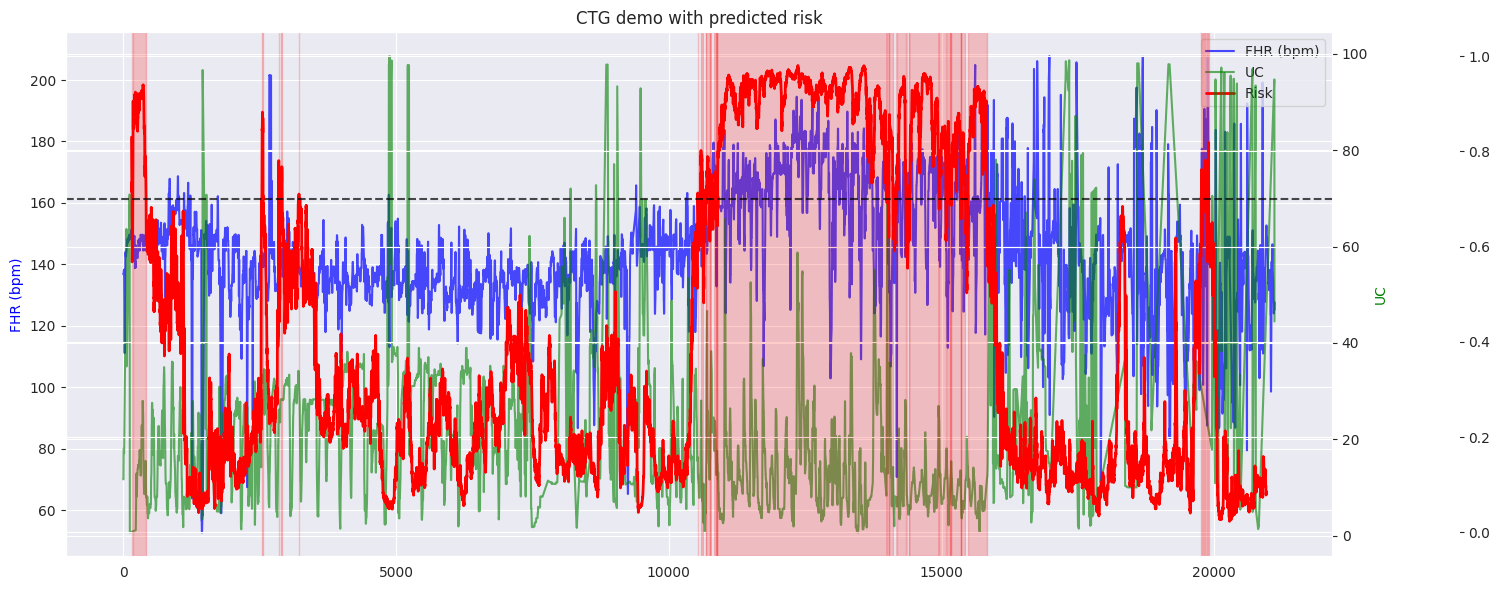

In [36]:
preds = run_model_on_df(df_demo, model, win_size=300, step=1)

alerts = postprocess_alerts(preds["proba"].values, method="duration", threshold=0.7, min_duration=3)

plot_demo_with_preds(df_demo, preds, threshold=0.7, alerts=alerts)

In [37]:
from collections import deque
from dataclasses import dataclass

STRIDE_S = 1

def minutes_to_frames(minutes: float, stride_s: int = STRIDE_S) -> int:
    return int(np.ceil(minutes * 60.0 / stride_s))

@dataclass
class AlarmConfig:
    on_thr: float = 0.80
    off_thr: float = 0.65
    on_minutes: float = 2.0
    off_minutes: float = 1.0
    on_ratio: float = 0.80
    off_ratio: float = 1.00

class AlarmState:
    def __init__(self, cfg: AlarmConfig, stride_s: int = STRIDE_S):
        self.cfg = cfg
        self.on_n  = minutes_to_frames(cfg.on_minutes,  stride_s)
        self.off_n = minutes_to_frames(cfg.off_minutes, stride_s)
        self.on_k  = int(np.ceil(self.on_n  * cfg.on_ratio))
        self.off_k = int(np.ceil(self.off_n * cfg.off_ratio))
        self.buf_on  = deque(maxlen=self.on_n)
        self.buf_off = deque(maxlen=self.off_n)
        self.is_on = False

    def update(self, proba: float) -> int:
        self.buf_on.append(  1 if proba > self.cfg.on_thr  else 0 )
        self.buf_off.append( 1 if proba < self.cfg.off_thr else 0 )
        if not self.is_on:
            if len(self.buf_on) == self.buf_on.maxlen and sum(self.buf_on) >= self.on_k:
                self.is_on = True
        else:
            if len(self.buf_off) == self.buf_off.maxlen and sum(self.buf_off) >= self.off_k:
                self.is_on = False
        return int(self.is_on)

In [38]:
def compute_alarm_timeseries(score_df: pd.DataFrame,
                             t_start: float | None = None,
                             t_end: float | None = None,
                             cfg: AlarmConfig = AlarmConfig(),
                             stride_s: int = 1) -> pd.DataFrame:
    """
    На вход: score_df с колонками ['t_center','proba'].
    На выход: равномерный ряд по секундам: ['t','proba','alarm'].
    """
    score_df = score_df.sort_values("t_center").reset_index(drop=True)
    if t_start is None:
        t_start = int(np.floor(score_df["t_center"].iloc[0]))
    if t_end is None:
        t_end = int(np.ceil(score_df["t_center"].iloc[-1]))

    t_grid = np.arange(t_start, t_end + 1, stride_s)

    # интерполяция вероятностей на каждую секунду (держим края по ближайшему значению)
    proba_grid = np.interp(
        t_grid,
        score_df["t_center"].values,
        score_df["proba"].values,
        left=score_df["proba"].iloc[0],
        right=score_df["proba"].iloc[-1],
    )

    alarm = []
    state = AlarmState(cfg=cfg, stride_s=stride_s)
    for p in proba_grid:
        alarm.append(state.update(p))

    return pd.DataFrame({"t": t_grid, "proba": proba_grid, "alarm": alarm})

In [39]:
def plot_alarm(df_uniform: pd.DataFrame, cfg: AlarmConfig = AlarmConfig(),
               score_df: pd.DataFrame | None = None):
    fig, ax = plt.subplots(figsize=(12, 4))

    # вероятность
    ax.plot(df_uniform["t"], df_uniform["proba"], label="proba")

    # пороги
    ax.hlines(cfg.on_thr,  df_uniform["t"].min(), df_uniform["t"].max(),
              linestyles="dashed", label=f"on_thr={cfg.on_thr}")
    ax.hlines(cfg.off_thr, df_uniform["t"].min(), df_uniform["t"].max(),
              linestyles="dotted", label=f"off_thr={cfg.off_thr}")

    # заливка интервалов тревоги
    in_alarm = df_uniform["alarm"].values.astype(bool)
    starts = np.where(np.diff(np.r_[False, in_alarm]) == 1)[0]
    ends   = np.where(np.diff(np.r_[in_alarm, False]) == -1)[0]
    for s, e in zip(starts, ends):
        ax.axvspan(df_uniform["t"].iloc[s], df_uniform["t"].iloc[e-1], alpha=0.15, color="red")

    # дискретная линия тревоги
    ax.step(df_uniform["t"], df_uniform["alarm"], where="post", label="alert", color="red")

    # точки окон модели
    if score_df is not None:
        ax.scatter(score_df["t_center"], score_df["proba"], s=12, alpha=0.6, label="window centers")

    ax.set_xlabel("t, s")
    ax.set_ylabel("proba")
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

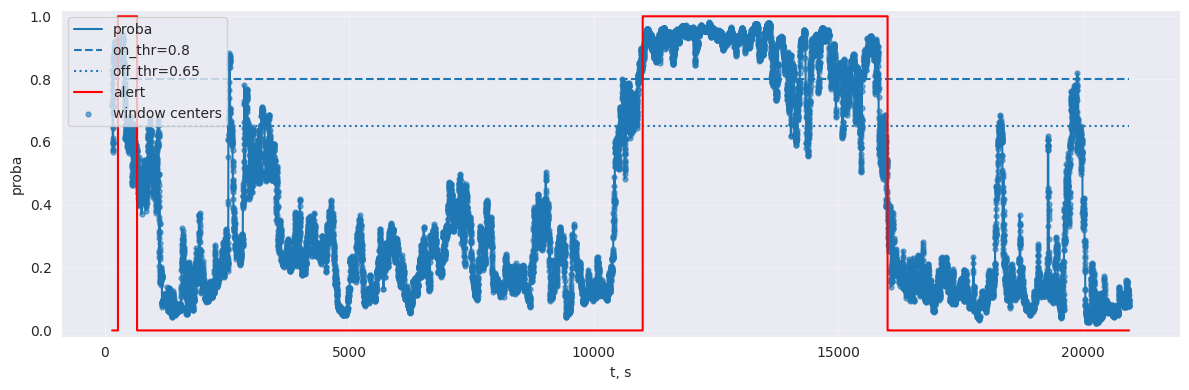

In [40]:
ts_alarm = compute_alarm_timeseries(preds, cfg=AlarmConfig(on_thr=0.80, off_thr=0.65, on_minutes=2.0, off_minutes=1.0))
plot_alarm(ts_alarm, cfg=AlarmConfig(on_thr=0.80, off_thr=0.65), score_df=preds)